# 1. Import required dependencies

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import torch
import torchvision.datasets as datasets

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight  # Import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.models import load_model

from torch.utils.data import DataLoader, TensorDataset

from PIL import Image

from transformers import ViTForImageClassification, ViTConfig

import pickle

import itertools


2025-02-25 18:12:10.960972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740487330.978253   68481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740487330.983699   68481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 18:12:11.002548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/mr/workspace/MajorProject/.venv_ensemble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found

# 2. Check GPU availability

In [3]:
print(tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using device: cuda


In [4]:
available = torch.cuda.is_available()
if available:
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


# 3. Load data

In [5]:
def load_data(path):
    import os
    import numpy as np
    from PIL import Image

    # Directory containing dataset
    data_dir = path  # Update this with your actual path

    # Parameters
    target_size = (224,224)  # Resize images to this size
    classes = sorted(os.listdir(data_dir))  # Automatically detect classes from subdirectories

    # Initialize lists to store images and labels
    images = []
    labels = []

    # Load all images and their labels
    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Open image, resize it, and convert to numpy array
                img = Image.open(img_path).resize(target_size).convert('RGB')
                plt.close()
                images.append(np.array(img))  # Add image to list
                labels.append(class_index)   # Assign numeric label based on class
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    # Convert lists to numpy arrays
    images = np.array(images)  # Shape: (num_samples, height, width, channels)
    labels = np.array(labels)  # Shape: (num_samples,)

    # Print dataset summary
    print("Total images loaded:", images.shape[0])
    print("Image shape:", images.shape[1:])
    print("Labels shape:", labels.shape)

    # One-hot encode labels (optional)
    from tensorflow.keras.utils import to_categorical
    labels = to_categorical(labels, num_classes=len(classes))

    print("One-hot encoded labels shape:", labels.shape)

    return images, labels


In [6]:
def laod_data_imggen(BatchSize, path, TargetSize= (224, 224)):
    image_gen = ImageDataGenerator(validation_split=0.15)
    data_dir = path
    batch_size = BatchSize
    target_size = TargetSize

    train_image_gen = image_gen.flow_from_directory(data_dir, 
                                            target_size=target_size,
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset="training")

    test_image_gen = image_gen.flow_from_directory(data_dir, 
                                            target_size=target_size, 
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False,
                                            subset="validation")
    
    X_train, y_train = next(train_image_gen)
    X_test, y_test = next(test_image_gen)

    return (X_train, y_train), (X_test, y_test), (train_image_gen, test_image_gen)

In [7]:
def load_data_torch(path):
    full_dataset = datasets.ImageFolder(root=path, transform=None)
    w0 = len(full_dataset) / (2 * 2520)
    w1 = len(full_dataset) / (2 * 5112)

    class_weights = torch.tensor([w0, w1], dtype=torch.float).to(device)

    return full_dataset, class_weights

# 4. Additional functions

In [8]:
def load(model_file, model_name = "google/vit-base-patch16-224-in21k"):
    if model_file.endswith('.keras'):
        model_type = "k"
        model = load_model(model_file)
    elif model_file.endswith('.pt'):
        model_type = "p"
        model = ViTForImageClassification.from_pretrained(model_name, num_labels=2)
        model.load_state_dict(torch.load(model_file))
        model.to(device)
        model.eval()
    else:
        raise ValueError("Unsupported model format: " + model_file)
    
    return model, model_type


In [9]:
def predict(model, mtype, x_test, batch_size):
    if mtype == "k":
        test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)
        predictions = model.predict(test_dataset, verbose=1)
        test_classes = np.argmax(predictions, axis=1)

    elif mtype == "p":
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
        test_dataset = TensorDataset(x_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.eval()
        test_classes = []

        with torch.no_grad():
            for batch in test_loader:
                images = batch[0].to(device)
                outputs = model(images)
                _, preds = torch.max(outputs.logits, dim=1)
                test_classes.extend(preds.cpu().numpy())

    return test_classes

In [10]:
def evaluate(model, mtype, x_test, y_test, batch_size, torch_class_weight= None):
    if mtype == "k":
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
        scores = model.evaluate(test_dataset, verbose=1)
        print('loss:', scores[0])
        print('accuracy:', scores[1])

        return scores
    
    elif mtype == "p":
        criterion = torch.nn.CrossEntropyLoss(weight=torch_class_weight)

        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)  # Convert to tensor
        #y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)  # Convert labels to tensor
        y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long).to(device)


        test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


        model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                logits = outputs.logits
                loss = criterion(logits, labels)
                total_loss += loss.item() * images.size(0)

                _, preds = torch.max(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += images.size(0)

        average_loss = total_loss / total
        accuracy = correct / total
        print('Loss:', average_loss)
        print('Accuracy:', accuracy)
        
        return (average_loss, accuracy)


In [11]:
def mostcommon(array):
    '''return the most common value of an array'''
    return np.bincount(array).argmax()

In [12]:
def weighted_vote(predictions, model_type, accuracy_records, num_classes=2):
    ''' return final_predict based on weighted_vote of all the learners in models
        weight is the the accuracy of each learner
    '''
    n_learners = predictions.shape[1]
    n_tests = predictions.shape[0]
    # final_predict = np.zeros((n_tests, 1), dtype="int64")
    probs = np.zeros((n_tests, num_classes))
    for i in range(n_learners):
        accuracy = accuracy_records[i]
        prediction = predictions[:, i]
        one_hot_pred = np.eye(num_classes)[prediction]

        if model_type[i] == "k":
            probs += accuracy * one_hot_pred
        elif model_type[i] == "p":
            probs += accuracy * one_hot_pred
        else:
            print("ERROR")
            probs = 0
    return np.argmax(probs, axis=1)


In [13]:

def majority_vote(predictions, model_type, accuracy_records):
    ''' return final_predict based on majority vote of all the learners in models
    '''
    n_tests = predictions.shape[0]

    final_predict = np.zeros((n_tests, 1), dtype="int64")

    for i in range(n_tests):
        final_predict[i] = mostcommon(predictions[i, :])

    return final_predict.flatten()

In [14]:
def save_details(filename, models, model_type, train_accuracy_records, test_accuracy_records, preds):
    
    data_to_save = {
        "models": models,
        "model_type": model_type,
        "train_accuracy_records": train_accuracy_records,
        "test_accuracy_records": test_accuracy_records,
        "preds": preds
    }

    with open(filename, "wb") as file:
        pickle.dump(data_to_save, file)

    print(f"Data saved to {filename}")

In [15]:
def retrieve_details(filename):
    with open(filename, "rb") as file:
        loaded_data = pickle.load(file)

    # Retrieve the data from the dictionary
    models = loaded_data["models"]
    model_type = loaded_data["model_type"]
    train_accuracy_records = loaded_data["train_accuracy_records"]
    test_accuracy_records = loaded_data["test_accuracy_records"]
    preds = loaded_data["preds"]

    print("Data loaded successfully")
    return models, model_type, train_accuracy_records, test_accuracy_records, preds

# Ensemble model

In [16]:
def ensemble_data_loader(batch_size, tf=True):
    images , labels = load_data('../breast_full_dataset')
    if tf:
        _, _, (train_img_gen, test_img_gen) = laod_data_imggen(batch_size, '../breast_full_dataset') ##
    else:
        (train_img_gen, test_img_gen) = (None, None)

    #x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size= 0.8, random_state= 42)
    x_train = images
    x_test = images
    y_train = labels
    y_test = labels
    print(f"\n\n X train size : {x_train.shape} \n X test size : {x_test.shape} \n Y train size : {y_train.shape} \n Y test size : {y_test.shape}")

    y_test_old = np.argmax(y_test, axis=1)

    return images, labels, train_img_gen, test_img_gen, x_train, x_test, y_train, y_test, y_test_old

In [17]:
def ensemble_tf_models(n_learners, saved_model_files, x_train, x_test, y_train, y_test, batch_size, filename):
    models = []
    model_type = []
    n_trains = x_train.shape[0]
    n_tests = x_test.shape[0]
    print(f"\n\n n train value : {n_trains} \n n test value : {n_tests}")
    train_accuracy_records = []
    test_accuracy_records = []
    preds = []

    for i in range(n_learners):
        model_file = saved_model_files[i]
        model, mtype = load(model_file)
        model_type.append(mtype)
        print(f"model {i} : {model_file}")
        scores = evaluate(model, mtype, x_test, y_test, batch_size)
        test_accuracy_records.append(scores[1])
        scores = evaluate(model, mtype, x_train, y_train, batch_size)
        train_accuracy_records.append(scores[1])
        models.append(model) # save base learner
        y_pred = predict(model, mtype, x_test, batch_size)
        preds.append(y_pred)
    
    #filename = "./test4/tf_ensemble_data.pkl"                       ############################################
    save_details(filename, models, model_type, train_accuracy_records, test_accuracy_records, preds)

    return models, model_type, train_accuracy_records, test_accuracy_records, preds

In [18]:
def ensemble_torch_models(n_learners, saved_model_files, x_train, x_test, y_train, y_test, batch_size, filename):
    models = []
    model_type = []
    n_trains = x_train.shape[0]
    n_tests = x_test.shape[0]
    print(f"\n\n n train value : {n_trains} \n n test value : {n_tests}")
    train_accuracy_records = []
    test_accuracy_records = []
    preds = []

    for i in range(n_learners):
        model_file = saved_model_files[i]
        model, mtype = load(model_file)
        model_type.append(mtype)
        print(f"model {i} : {model_file}")
        scores = evaluate(model, mtype, x_test, y_test, batch_size)
        test_accuracy_records.append(scores[1])
        scores = evaluate(model, mtype, x_train, y_train, batch_size)
        train_accuracy_records.append(scores[1])
        models.append(model) # save base learner
        y_pred = predict(model, mtype, x_test, batch_size)
        preds.append(y_pred)

    #filename = "./test4/pt_ensemble_data.pkl"                       ############################################
    save_details(filename, models, model_type, train_accuracy_records, test_accuracy_records, preds)

    return models, model_type, train_accuracy_records, test_accuracy_records, preds

In [19]:
def ensemble(n_learners, saved_model_files, model_type, predictions, votefuns, x_train, x_test, y_test_old, train_accuracy_records, test_accuracy_records, filename, file_prefix= ""):
    n_trains = x_train.shape[0]
    n_tests = x_test.shape[0]

    filename = file_prefix + filename
    print(filename)
    out_file = open(filename, "a")
    out_file.write("--------------------------------------------\n")
    for votefun in votefuns:
        final_predict = votefun(predictions, model_type, train_accuracy_records)
        final_predict = final_predict.reshape(-1)
        print(final_predict.shape)

        errors = np.count_nonzero(final_predict.reshape((n_tests, )) - y_test_old.reshape((n_tests,)))
        out_file.write("votefun is\n")
        out_file.write(str(votefun) + "\n")
        out_file.write('ensemble test accuracy: %0.6f \n' % ((n_tests - errors)/float(n_tests)))
        print(f"votefun is {votefun}")
        print('ensemble test accuracy: %0.6f' % ((n_tests - errors)/float(n_tests)))
        for i in range(n_learners):
            print("learner %d (model_file = %s): %0.6f" % (i, saved_model_files[i], test_accuracy_records[i]))
            out_file.write("learner %d (model_file = %s): %0.6f\n" % (i, saved_model_files[i], test_accuracy_records[i]))
    out_file.close()

    return final_predict

# Testing

In [20]:
batch_size = 8
# k_saved_model_files = ["test2/t2_breast_IRNAdam-epoch13.keras", "test2/t2_breast_VGGAdam-epoch10.keras", 'test2/t2_breast_Xception_VGG_PreProcess-epoch12.keras', 'test2/t2_breast_DenseNet-epoch13.keras']
k_saved_model_files = ["test3/t3_breast_IRNAdam_NoPreProcess-epoch12.keras", "test2/t2_breast_VGGAdam-epoch10.keras", 'test3/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras', 'test3/t3_breast_ResNet50_NoPreProcess-epoch15.keras']
p_saved_model_files = ['test3/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch7.pt']
k_n_learners = len(k_saved_model_files)
p_n_learners = len(p_saved_model_files)


In [20]:
batch_size = 8
images, labels, train_img_gen, test_img_gen, x_train, x_test, y_train, y_test, y_test_old = ensemble_data_loader(batch_size, tf= True)

Total images loaded: 7632
Image shape: (224, 224, 3)
Labels shape: (7632,)
One-hot encoded labels shape: (7632, 2)
Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


 X train size : (7632, 224, 224, 3) 
 X test size : (7632, 224, 224, 3) 
 Y train size : (7632, 2) 
 Y test size : (7632, 2)


In [21]:
k_saved_model_files1 = ["./final models/t2_breast_VGGAdam-epoch10.keras", "./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras", "./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras", "./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras"]
k_n_learners1 = len(k_saved_model_files1)

k_saved_model_files2 = ["./final models/t2_breast_VGGAdam-epoch10.keras", "./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras", "./final models/breast_Xception-epoch06_.keras", "./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras"]
k_n_learners2 = len(k_saved_model_files2)

k_saved_model_files3 = ["./final models/t2_breast_VGGAdam-epoch10.keras", "./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras", "./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras", "./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras", "./final models/breast_Xception-epoch06_.keras"]
k_n_learners3 = len(k_saved_model_files3)

k_saved_model_files4 = ["./final models/breast_VGGAdam-epoch06.keras", "./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras", "./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras", "./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras", "./final models/breast_Xception-epoch06_.keras"]
k_n_learners4 = len(k_saved_model_files4)

p_saved_model_files = ['./final models/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch4.pt']
p_n_learners = len(p_saved_model_files)

In [23]:


k_models, k_model_type, k_train_accuracy_records, k_test_accuracy_records, k_preds = ensemble_tf_models(k_n_learners4, k_saved_model_files4, x_train, x_test, y_train, y_test, batch_size, "./test4/tf_v3_ensemble.pkl")
print(k_models, k_model_type, k_train_accuracy_records, k_test_accuracy_records, k_preds)



 n train value : 7632 
 n test value : 7632


I0000 00:00:1740484845.599869   63444 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4778 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


model 0 : ./final models/breast_VGGAdam-epoch06.keras


2025-02-25 17:30:47.050472: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1148829696 exceeds 10% of free system memory.
2025-02-25 17:30:47.992699: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1148829696 exceeds 10% of free system memory.
2025-02-25 17:30:48.665469: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1148829696 exceeds 10% of free system memory.
I0000 00:00:1740484849.663706   63777 service.cc:148] XLA service 0x7d8be000b5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740484849.663765   63777 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-02-25 17:30:49.680078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740484849.763734   63777 cuda_dnn.cc:529] L

  4/954 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step - accuracy: 0.8203 - loss: 0.6006

I0000 00:00:1740484853.444458   63777 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


954/954 ━━━━━━━━━━━━━━━━━━━━ 69s 67ms/step - accuracy: 0.8285 - loss: 0.5223
loss: 0.4838637411594391
accuracy: 0.8434224128723145


2025-02-25 17:31:57.834677: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1148829696 exceeds 10% of free system memory.
2025-02-25 17:31:58.704806: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1148829696 exceeds 10% of free system memory.


954/954 ━━━━━━━━━━━━━━━━━━━━ 102s 106ms/step - accuracy: 0.8285 - loss: 0.5223
loss: 0.4838637411594391
accuracy: 0.8434224128723145
954/954 ━━━━━━━━━━━━━━━━━━━━ 196s 205ms/step
model 1 : ./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras
954/954 ━━━━━━━━━━━━━━━━━━━━ 132s 123ms/step - accuracy: 0.9479 - loss: 0.2586
loss: 0.14943473041057587
accuracy: 0.9663259983062744
954/954 ━━━━━━━━━━━━━━━━━━━━ 106s 111ms/step - accuracy: 0.9479 - loss: 0.2586
loss: 0.14943473041057587
accuracy: 0.9663259983062744
954/954 ━━━━━━━━━━━━━━━━━━━━ 163s 162ms/step
model 2 : ./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras


2025-02-25 17:44:00.958282: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-25 17:44:02.364030: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-25 17:44:04.134278: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-25 17:44:05.223876: W external/local_xla/xla/ts

954/954 ━━━━━━━━━━━━━━━━━━━━ 141s 138ms/step - accuracy: 0.6010 - loss: 0.6773
loss: 0.6347607970237732
accuracy: 0.6310272812843323
954/954 ━━━━━━━━━━━━━━━━━━━━ 108s 113ms/step - accuracy: 0.6010 - loss: 0.6773
loss: 0.6347607970237732
accuracy: 0.6310272812843323
954/954 ━━━━━━━━━━━━━━━━━━━━ 180s 186ms/step
model 3 : ./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras


2025-02-25 17:51:18.023739: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-25 17:51:18.259021: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivati

954/954 ━━━━━━━━━━━━━━━━━━━━ 106s 103ms/step - accuracy: 0.9547 - loss: 0.2214
loss: 0.20566315948963165
accuracy: 0.9585953950881958
954/954 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.9547 - loss: 0.2214
loss: 0.20566315948963165
accuracy: 0.9585953950881958
954/954 ━━━━━━━━━━━━━━━━━━━━ 131s 134ms/step
model 4 : ./final models/breast_Xception-epoch06_.keras
954/954 ━━━━━━━━━━━━━━━━━━━━ 184s 192ms/step - accuracy: 0.9654 - loss: 0.1224
loss: 0.10213527083396912
accuracy: 0.9697327017784119
954/954 ━━━━━━━━━━━━━━━━━━━━ 155s 162ms/step - accuracy: 0.9654 - loss: 0.1224
loss: 0.10213527083396912
accuracy: 0.9697327017784119
954/954 ━━━━━━━━━━━━━━━━━━━━ 303s 317ms/step
Data saved to ./test4/tf_v3_ensemble.pkl
[<Functional name=functional_1, built=True>, <Functional name=functional, built=True>, <Functional name=functional, built=True>, <Functional name=functional, built=True>, <Functional name=functional_2, built=True>] ['k', 'k', 'k', 'k', 'k'] [0.8434224128723145, 0.966325998306274

In [ ]:


k_models, k_model_type, k_train_accuracy_records, k_test_accuracy_records, k_preds = ensemble_tf_models(k_n_learners2, k_saved_model_files2, x_train, x_test, y_train, y_test, batch_size, "./test4/tf_v2_ensemble.pkl")
print(k_models, k_model_type, k_train_accuracy_records, k_test_accuracy_records, k_preds)

In [ ]:


p_models, p_model_type, p_train_accuracy_records, p_test_accuracy_records, p_preds = ensemble_torch_models(p_n_learners, p_saved_model_files, x_train, x_test, y_train, y_test, batch_size, "./test4/pt_v1_ensemble.pkl")
print(p_models, p_model_type, p_train_accuracy_records, p_test_accuracy_records, p_preds)

In [23]:
k_models, k_model_type, k_train_accuracy_records, k_test_accuracy_records, k_preds = retrieve_details("./test4/tf_v3_ensemble.pkl")
#print(k_models, k_model_type, k_train_accuracy_records, k_test_accuracy_records, k_preds)

I0000 00:00:1740487365.211685   68481 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4778 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Data loaded successfully


In [23]:
p_models, p_model_type, p_train_accuracy_records, p_test_accuracy_records, p_preds = retrieve_details("./test4/pt_v1_ensemble.pkl")
#print(p_models, p_model_type, p_train_accuracy_records, p_test_accuracy_records, p_preds)

Data loaded successfully


In [24]:
votefuns = [weighted_vote,  majority_vote]
n_learners = k_n_learners1 + p_n_learners
saved_model_files = k_saved_model_files2 + p_saved_model_files                      #######################
model_types = k_model_type + p_model_type
train_accuracy_records = k_train_accuracy_records + p_train_accuracy_records
test_accuracy_records = k_test_accuracy_records + p_test_accuracy_records
predictions = k_preds + p_preds

predictions_array = np.stack(predictions, axis=1)

filename = "./test4/Ensemble_v2.txt"


In [24]:
votefuns = [weighted_vote,  majority_vote]
n_learners = k_n_learners3
saved_model_files = k_saved_model_files3               #######################
model_types = k_model_type 
train_accuracy_records = k_train_accuracy_records 
test_accuracy_records = k_test_accuracy_records 
predictions = k_preds 

predictions_array = np.stack(predictions, axis=1)

filename = "./test4/Ensemble_v3.txt"


In [25]:
saved_model_files

['./final models/t2_breast_VGGAdam-epoch10.keras',
 './final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras',
 './final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras',
 './final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras',
 './final models/breast_Xception-epoch06_.keras']

In [26]:
predictions_array

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [27]:
predictions_array.shape

(7632, 5)

In [28]:
y_pred = ensemble(n_learners, saved_model_files, model_types, predictions_array, votefuns, x_train, x_test, y_test_old, train_accuracy_records, test_accuracy_records, filename, file_prefix= "")

./test4/Ensemble_v3.txt
(7632,)
votefun is <function weighted_vote at 0x7aeccad38040>
ensemble test accuracy: 0.974188
learner 0 (model_file = ./final models/t2_breast_VGGAdam-epoch10.keras): 0.843422
learner 1 (model_file = ./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras): 0.966326
learner 2 (model_file = ./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras): 0.631027
learner 3 (model_file = ./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras): 0.958595
learner 4 (model_file = ./final models/breast_Xception-epoch06_.keras): 0.969733
(7632,)
votefun is <function majority_vote at 0x7aeccb848040>
ensemble test accuracy: 0.974188
learner 0 (model_file = ./final models/t2_breast_VGGAdam-epoch10.keras): 0.843422
learner 1 (model_file = ./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras): 0.966326
learner 2 (model_file = ./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras): 0.631027
learner 3 (model_file = ./final models/t3

# analysis

In [24]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Ensemble Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()






In [26]:
def ensemble_testing(model_type, predictions, votefuns, train_accuracy_records, test_accuracy_records):

    for votefun in votefuns:
        final_predict = votefun(predictions, model_type, train_accuracy_records)
        final_predict = final_predict.reshape(-1)
        print(final_predict.shape)

    return final_predict

In [27]:
votefuns = [weighted_vote]
model_types = k_model_type + p_model_type
train_accuracy_records = k_train_accuracy_records + p_train_accuracy_records
test_accuracy_records = k_test_accuracy_records + p_test_accuracy_records
predictions = k_preds + p_preds

predictions_array = np.stack(predictions, axis=1)

y_pred = ensemble_testing(model_types, predictions_array, votefuns, train_accuracy_records, test_accuracy_records)


(7632,)


In [28]:
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [37]:
y_test_prediction = np.argmax(y_test, axis= 1)
y_test_prediction

array([0, 0, 0, ..., 1, 1, 1])

Normalized confusion matrix
[[0.94365079 0.05634921]
 [0.00371674 0.99628326]]


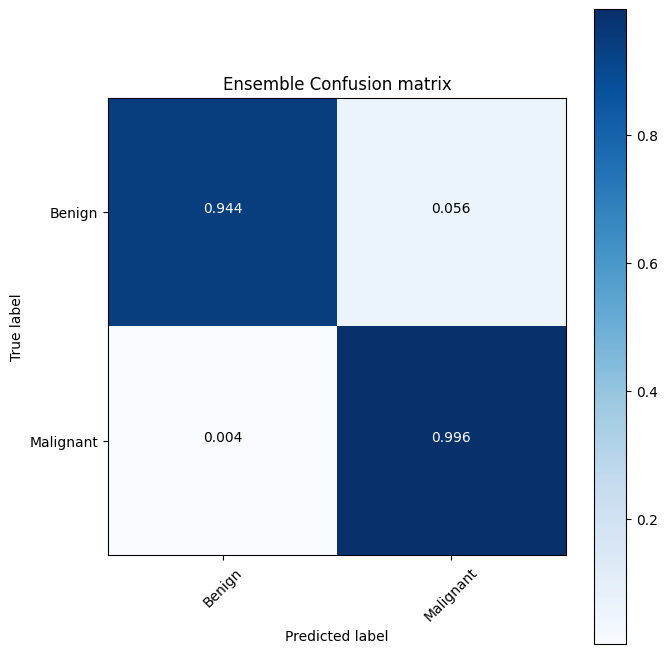

In [39]:
cm = confusion_matrix(y_test_prediction, y_pred)
cm_plot_labels = ['Benign', 'Malignant']
plot_confusion_matrix(cm, cm_plot_labels)

In [43]:
print(classification_report(y_test_prediction, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2520
           1       0.97      1.00      0.98      5112

    accuracy                           0.98      7632
   macro avg       0.98      0.97      0.98      7632
weighted avg       0.98      0.98      0.98      7632



In [44]:
votefuns = [majority_vote]
model_types = k_model_type + p_model_type
train_accuracy_records = k_train_accuracy_records + p_train_accuracy_records
test_accuracy_records = k_test_accuracy_records + p_test_accuracy_records
predictions = k_preds + p_preds

predictions_array = np.stack(predictions, axis=1)

y_pred = ensemble_testing(model_types, predictions_array, votefuns, train_accuracy_records, test_accuracy_records)


(7632,)


Normalized confusion matrix
[[0.94365079 0.05634921]
 [0.00371674 0.99628326]]


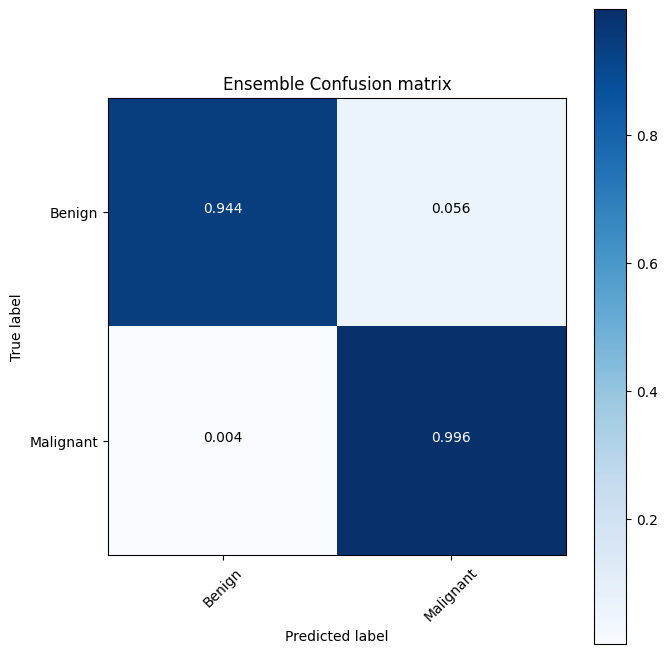

In [45]:
cm = confusion_matrix(y_test_prediction, y_pred)
cm_plot_labels = ['Benign', 'Malignant']
plot_confusion_matrix(cm, cm_plot_labels)

In [46]:
print(classification_report(y_test_prediction, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2520
           1       0.97      1.00      0.98      5112

    accuracy                           0.98      7632
   macro avg       0.98      0.97      0.98      7632
weighted avg       0.98      0.98      0.98      7632

